In [1]:
import pandas as pd
import requests
from zipfile import ZipFile as zzip
import fiona
import json
from shapely.geometry import Point
import shapely
import geopandas as gpd
import pyogrio


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [53]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Download Lion Data
Skip this if your data already has segment ids

In [16]:
LION_ZIP_DIR = "input_data/nyclion_19b.zip"
GDB_FILE = r"input_data/lion/lion.gdb"
OUTPUT_DIR = "output/"

In [110]:
# Download and store lion files
url = r"https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nyclion_19b.zip"

# download the file contents in binary format
r = requests.get(url)
# open method to open a file on your system and write the contents
with open(LION_ZIP_DIR, "wb") as file:
    file.write(r.content)

# opening the zip file in READ mode
with zzip(LION_ZIP_DIR, 'r') as file:
    # printing all the contents of the zip file
    file.printdir()

    # extracting all the files
    file.extractall("/kaggle/working/")
    print('Done!')

KeyboardInterrupt: 

In [17]:
lion_gdf = gpd.read_file(GDB_FILE, engine='pyogrio', layer='lion')

In [18]:
lion_gdf = lion_gdf[lion_gdf.LBoro == 1]

In [ ]:
lion_gdf['SegmentID'].unique().size

28497

In [ ]:
SERVICE_311_DATA = "/kaggle/input/noise-data/311_Service_Requests_2024_Noise.csv"
CONSTRUCTION_DATA = "/kaggle/input/noise-data/Active_Projects_Under_Construction_20240531.csv"
SOUND_TAGS = "/kaggle/input/noise-data/SONYC_Urban_Sound_Tagging.csv"
STREET_CLOSURES = "/kaggle/input/noise-data/Street_Closures_due_to_construction_activities_by_Block_20240531.csv"

# 311 Service Requests

## Clean and create csv
Skip this if you already have noise complaints in the input data

In [ ]:
df = pd.read_csv(SERVICE_311_DATA)
df.head()

/tmp/ipykernel_33/2009293655.py:1: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(SERVICE_311_DATA)


,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Bridge Highway Segment,Latitude,Longitude,Location,Zip Codes,Community Districts,Borough Boundaries,City Council Districts,Police Precincts,Police Precinct
0,59896272,01/01/2024 12:00:00 AM,01/02/2024 12:00:01 AM,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,Restaurant/Bar/Deli/Bakery,11211.0,145 GRAND STREET EXTENSION,...,NaN,40.710675,-73.954050,"(40.710675306389646, -73.954050047883)",17613.0,36.0,2.0,30.0,56.0,56.0
1,59898042,01/01/2024 12:00:00 AM,01/02/2024 09:24:45 AM,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,Restaurant/Bar/Deli/Bakery,10462.0,711 MORRIS PARK AVENUE,...,NaN,40.845340,-73.865594,"(40.84533975748463, -73.86559379953668)",11271.0,59.0,5.0,22.0,32.0,32.0
2,59894610,01/01/2024 12:00:00 AM,01/02/2024 09:46:32 AM,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,Restaurant/Bar/Deli/Bakery,10304.0,7 NAVY PIER COURT,...,NaN,40.628828,-74.074387,"(40.628827651071944, -74.0743866176229)",10691.0,4.0,1.0,13.0,74.0,74.0
3,59899838,01/01/2024 12:00:00 AM,01/02/2024 09:42:25 AM,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,Restaurant/Bar/Deli/Bakery,10022.0,1069 1 AVENUE,...,NaN,40.759192,-73.962290,"(40.759191822016476, -73.96228991313669)",12419.0,71.0,4.0,1.0,9.0,9.0
4,59887043,01/01/2024 12:00:20 AM,01/01/2024 12:41:01 AM,NYPD,New York City Police Department,Illegal Fireworks,NaN,Street/Sidewalk,11228.0,7223 FORT HAMILTON PARKWAY,...,NaN,40.627094,-74.014497,"(40.62709413549678, -74.01449651007135)",13511.0,10.0,2.0,44.0,41.0,41.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1305481 entries, 0 to 1305480
Data columns (total 47 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   Unique Key                      1305481 non-null  int64  
 1   Created Date                    1305481 non-null  object 
 2   Closed Date                     1203594 non-null  object 
 3   Agency                          1305481 non-null  object 
 4   Agency Name                     1305481 non-null  object 
 5   Complaint Type                  1305481 non-null  object 
 6   Descriptor                      1272518 non-null  object 
 7   Location Type                   1145069 non-null  object 
 8   Incident Zip                    1290909 non-null  float64
 9   Incident Address                1255095 non-null  object 
 10  Street Name                     1255055 non-null  object 
 11  Cross Street 1                  886523 non-null   object 
 12  

## Data Cleaning


In [ ]:
# Extract the columns we care about
df_complaints = df[["Created Date", "Complaint Type", "Descriptor", "Incident Address", "Address Type", "Borough", "Latitude", "Longitude", "Location Type"]]

In [ ]:
# Filter to manhattan only
df_complaints = df_complaints[df["Borough"] == "MANHATTAN"]
df_complaints["Borough"].unique()

array(['MANHATTAN'], dtype=object)

In [ ]:
# Filter down to only noise complaints
df_complaints = df_complaints[df_complaints['Complaint Type'].str.contains("Noise|Loud")]
print(df_complaints["Complaint Type"].unique())

['Noise - Residential' 'Noise - Street/Sidewalk' 'Noise - Commercial'
 'Noise - Helicopter' 'Noise - Vehicle' 'Noise' 'Noise - Park'
 'Noise - House of Worship']


In [ ]:
df_complaints[df_complaints["Complaint Type"] == "Noise - Residential"]["Descriptor"].unique()

array(['Loud Music/Party', 'Banging/Pounding', 'Loud Talking',
       'Loud Television'], dtype=object)

In [ ]:
# Drop the residential noise complaints - not relevant
df_complaints = df_complaints[df_complaints["Complaint Type"] != "Noise - Residential"]

In [ ]:
df_complaints.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46885 entries, 52 to 1305480
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Created Date      46885 non-null  object 
 1   Complaint Type    46885 non-null  object 
 2   Descriptor        46885 non-null  object 
 3   Incident Address  45499 non-null  object 
 4   Address Type      46884 non-null  object 
 5   Borough           46885 non-null  object 
 6   Latitude          46446 non-null  float64
 7   Longitude         46446 non-null  float64
 8   Location Type     37751 non-null  object 
dtypes: float64(2), object(7)
memory usage: 3.6+ MB


In [ ]:
df_complaints.head()

,Created Date,Complaint Type,Descriptor,Incident Address,Address Type,Borough,Latitude,Longitude,Location Type
52,01/01/2024 12:07:40 AM,Noise - Street/Sidewalk,Loud Music/Party,5 SEAMAN AVENUE,ADDRESS,MANHATTAN,40.866417,-73.927737,Street/Sidewalk
66,01/01/2024 12:09:17 AM,Noise - Commercial,Loud Music/Party,58 STONE STREET,ADDRESS,MANHATTAN,40.704448,-74.010164,Club/Bar/Restaurant
75,01/01/2024 12:10:52 AM,Noise - Commercial,Loud Music/Party,83 PEARL STREET,ADDRESS,MANHATTAN,40.704055,-74.010153,Club/Bar/Restaurant
102,01/01/2024 12:13:35 AM,Noise - Commercial,Loud Music/Party,127 STANTON STREET,ADDRESS,MANHATTAN,40.720856,-73.986558,Store/Commercial
108,01/01/2024 12:14:25 AM,Noise - Commercial,Loud Music/Party,518 WEST 27 STREET,ADDRESS,MANHATTAN,40.750662,-74.003432,Club/Bar/Restaurant


# Segment ID translations
Skip this if you already have translations

In [ ]:
def load_segment_ids():
    new_segment_ids = {}
    # Opening JSON file
    try:
        f = open(f"/kaggle/working/output/segment_id_dict.json")
    except:
        f = open(f"/kaggle/input/segment-id-mappings/segment_id_dict.json")
    data = json.load(f)
    for key in data.keys():
        coordinates_tuple = tuple(map(float, key.split(',')))
        new_segment_ids[coordinates_tuple] = data[key]

    return new_segment_ids

In [ ]:
def get_segment_id_from_coords(lat, lng):
    point = Point(lng, lat)
    if lion_gdf.crs.is_geographic:
        point_gdf = gpd.GeoDataFrame([{'geometry': point}], crs=lion_gdf.crs)
    else:
        point_gdf = gpd.GeoDataFrame([{'geometry': point}], crs="EPSG:4326").to_crs(lion_gdf.crs)
    
    lion_gdf['distance'] = lion_gdf.geometry.distance(point_gdf.iloc[0].geometry)
    nearest_segment = lion_gdf.loc[lion_gdf['distance'].idxmin()]
    segment_id = nearest_segment['SegmentID']
    return segment_id

In [ ]:
# Function which iterates over each row in the df and
# fills in the segment id for each lat/lng
def add_segment_id_column(df):
    global segment_ids
    updated_coordinates = []
    for idx, row in df.iterrows():
        if (idx % 1000 == 0):
            print(f"Completed {idx} rows")
            rows_left = df['SegmentId'].isnull().sum()
            print(f'Rows left: {rows_left}')
        try:
            lat = round(row['Latitude'], 4)
            lng = round(row['Longitude'], 4)
            if (lat, lng) not in updated_coordinates: # Need to update this column
                if (lat, lng) not in segment_ids.keys(): # Need to calculate
#                     print(f'Calculating segment for ({lat}, {lng})')
                    segment_id = get_segment_id_from_coords(lat, lng)
                    segment_ids[(lat, lng)] = segment_id
                else: # We can pull from our dict
                    segment_id = segment_ids[(lat, lng)]
                matching_rows = df[(round(df.Latitude, 4) == lat) & (round(df.Longitude, 4) == lng)]
#                 print(f'Updating: {len(matching_rows)}')
                df.loc[(round(df.Latitude, 4) == lat) & (round(df.Longitude, 4) == lng), 'SegmentId'] = segment_id
                
                rows_left = df['SegmentId'].isnull().sum()
#                 print(f'Rows left: {rows_left}')
                updated_coordinates.append((lat, lng))

                if rows_left == 0:
                    return
            else:
                # Any seg
                pass
        except Exception as e:
#             print(f"Unable to translate ({lat}, {lng}), skipping", e)
            pass


In [ ]:
segment_ids = load_segment_ids()

In [ ]:
print(list(segment_ids.keys())[:4])
print(list(segment_ids.values())[:4])
print(len(list(segment_ids)))

[(40.74307, -73.98426), (40.799446, -73.968376), (40.79502, -73.94425), (40.762455, -73.985985)]
['0033181', '0038133', '0038090', '0034097']
83784


In [ ]:
print("Unique lat/long: ", len(df_complaints.drop_duplicates(subset=['Latitude', 'Longitude'])))
print("Unique lat/long/time: ", len(df_complaints.drop_duplicates(subset=['Latitude', 'Longitude', 'Created Date'])))

Unique lat/long:  13277
Unique lat/long/time:  46800


In [ ]:
add_segment_id_column(df_complaints)

Completed 14000 rows
Rows left: 37344
Completed 17000 rows
Rows left: 36615
Completed 27000 rows
Rows left: 35139
Completed 48000 rows
Rows left: 32302
Completed 78000 rows
Rows left: 30207
Completed 101000 rows
Rows left: 28681
Completed 110000 rows
Rows left: 27702
Completed 113000 rows
Rows left: 27193
Completed 121000 rows
Rows left: 26759
Completed 125000 rows
Rows left: 26480
Completed 248000 rows
Rows left: 21750
Completed 249000 rows
Rows left: 21596
Completed 313000 rows
Rows left: 19086
Completed 314000 rows
Rows left: 18988
Completed 339000 rows
Rows left: 17933
Completed 348000 rows
Rows left: 17651
Completed 357000 rows
Rows left: 17333
Completed 379000 rows
Rows left: 16316
Completed 382000 rows
Rows left: 16104
Completed 389000 rows
Rows left: 15989
Completed 404000 rows
Rows left: 15687
Completed 414000 rows
Rows left: 15542
Completed 429000 rows
Rows left: 15150
Completed 486000 rows
Rows left: 13736
Completed 528000 rows
Rows left: 12834
Completed 535000 rows
Rows lef

In [ ]:
print(len(list(segment_ids)))

93612


In [ ]:
segment_ids_as_json = {}
for key in segment_ids.keys():
    tuple_str = ",".join([str(key[0]), str(key[1])])
    segment_ids_as_json[tuple_str] = segment_ids[key]

# Save segment ids for future use
with open(f"/kaggle/working/segment_id_dict.json", "w") as outfile: 
    json.dump(segment_ids_as_json, outfile)
    print("Segment ids saved")

Segment ids saved


In [ ]:
df_complaints.head()

,Created Date,Complaint Type,Descriptor,Incident Address,Address Type,Borough,Latitude,Longitude,Location Type,SegmentId
52,01/01/2024 12:07:40 AM,Noise - Street/Sidewalk,Loud Music/Party,5 SEAMAN AVENUE,ADDRESS,MANHATTAN,40.866417,-73.927737,Street/Sidewalk,0072606
66,01/01/2024 12:09:17 AM,Noise - Commercial,Loud Music/Party,58 STONE STREET,ADDRESS,MANHATTAN,40.704448,-74.010164,Club/Bar/Restaurant,0023140
75,01/01/2024 12:10:52 AM,Noise - Commercial,Loud Music/Party,83 PEARL STREET,ADDRESS,MANHATTAN,40.704055,-74.010153,Club/Bar/Restaurant,0023138
102,01/01/2024 12:13:35 AM,Noise - Commercial,Loud Music/Party,127 STANTON STREET,ADDRESS,MANHATTAN,40.720856,-73.986558,Store/Commercial,0032870
108,01/01/2024 12:14:25 AM,Noise - Commercial,Loud Music/Party,518 WEST 27 STREET,ADDRESS,MANHATTAN,40.750662,-74.003432,Club/Bar/Restaurant,0236993


In [ ]:
df_complaints = df_complaints.dropna(subset=['SegmentId'])

In [ ]:
df_complaints.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46446 entries, 52 to 1305480
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Created Date      46446 non-null  object 
 1   Complaint Type    46446 non-null  object 
 2   Descriptor        46446 non-null  object 
 3   Incident Address  45060 non-null  object 
 4   Address Type      46446 non-null  object 
 5   Borough           46446 non-null  object 
 6   Latitude          46446 non-null  float64
 7   Longitude         46446 non-null  float64
 8   Location Type     37491 non-null  object 
 9   SegmentId         46446 non-null  object 
dtypes: float64(2), object(8)
memory usage: 3.9+ MB


In [ ]:
complaints_csv = f"/kaggle/working/noise-complaints.csv"
df_complaints.to_csv(complaints_csv, index=False)
print(f"Complaints saved: {complaints_csv}")

Complaints saved: /kaggle/working/noise-complaints.csv


## Inspect features

In [20]:
try:
    df_complaints = pd.read_csv(f"input_data/noise-complaints.csv",  dtype={"SegmentId": str})
except:
    df_complaints = pd.read_csv(f"output/noise-complaints.csv",  dtype={"SegmentId": str})
df_complaints.head()

,Created Date,Complaint Type,Descriptor,Incident Address,Address Type,Borough,Latitude,Longitude,Location Type,SegmentId
0,2024-01-01 00:00:00,Noise - Street/Sidewalk,Loud Music/Party,5 SEAMAN AVENUE,ADDRESS,MANHATTAN,40.866417,-73.927737,Street/Sidewalk,72606
1,2024-01-01 00:00:00,Noise - Commercial,Loud Music/Party,58 STONE STREET,ADDRESS,MANHATTAN,40.704448,-74.010164,Club/Bar/Restaurant,23140
2,2024-01-01 00:00:00,Noise - Commercial,Loud Music/Party,83 PEARL STREET,ADDRESS,MANHATTAN,40.704055,-74.010153,Club/Bar/Restaurant,23138
3,2024-01-01 00:00:00,Noise - Commercial,Loud Music/Party,127 STANTON STREET,ADDRESS,MANHATTAN,40.720856,-73.986558,Store/Commercial,32870
4,2024-01-01 00:00:00,Noise - Commercial,Loud Music/Party,518 WEST 27 STREET,ADDRESS,MANHATTAN,40.750662,-74.003432,Club/Bar/Restaurant,236993


In [5]:
# Check for null values
df_complaints.isnull().sum()

Created Date           0
Complaint Type         0
Descriptor             0
Incident Address    1223
Address Type           0
Borough                0
Latitude               0
Longitude              0
Location Type       8411
SegmentId              0
dtype: int64

In [6]:
df_complaints.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41935 entries, 0 to 41934
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Created Date      41935 non-null  object 
 1   Complaint Type    41935 non-null  object 
 2   Descriptor        41935 non-null  object 
 3   Incident Address  40712 non-null  object 
 4   Address Type      41935 non-null  object 
 5   Borough           41935 non-null  object 
 6   Latitude          41935 non-null  float64
 7   Longitude         41935 non-null  float64
 8   Location Type     33524 non-null  object 
 9   SegmentId         41935 non-null  object 
dtypes: float64(2), object(8)
memory usage: 3.2+ MB


### Set up some helper functions
We are going to try several combinations of groupings etc. Here are some helper functions for evaluating the df

In [32]:
def check_segment_coverage(lion_gdf, df):
    # Check segment coverage
    total_segments = lion_gdf['SegmentID'].unique().size
    actual_segments = df['SegmentId'].unique().size
    print(f"{actual_segments}/{total_segments} represented in dataset ({round((actual_segments / total_segments) * 100)}%)")

In [88]:
def check_date_coverage(df):
    # Check date range
    min_date = df['Timestamp_Rounded'].min()
    max_date = df['Timestamp_Rounded'].max()
    print(f"Date range: {min_date} - {max_date}")

    # Calculate the difference in days
    date_range = pd.date_range(min_date, max_date, freq="h")
    print(f"Expect {date_range.size} datetime entries")

    # Check distinct datetimes
    actual_days = df['Timestamp_Rounded'].unique().size
    print(f"have {actual_days} days covered")
    return date_range

In [84]:
def map_segments(lion_gdf, df):
    lion_gdf = lion_gdf.to_crs(4326)
    df_map = pd.DataFrame()
    segment_ids = df['SegmentId'].unique()
    # df_map['SegmentId'] = segment_ids
    lats = []
    lngs = []

    # For each segment id, get a lat/lng
    for segment_id in segment_ids:
        y = lion_gdf.query(f'SegmentID == "{segment_id}"').geometry.centroid.y
        lats.append(y.values[0])
        x = lion_gdf.query(f'SegmentID == "{segment_id}"').geometry.centroid.x
        lngs.append(x.values[0])

    # df_map['Latitude'] = lats  
    # df_map['Longitude'] = lngs  
    df_map = pd.DataFrame.from_dict({'SegmentId': segment_ids, 'Latitude': lats, 'Longitude': lngs})
    
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=df_map, x='Longitude', y='Latitude', palette='viridis', sizes=(2, 100), legend=True)
    plt.title('Geographical Distribution of Quantity')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

## Approach 1: Group by the month/hour/day/segment
This is the finest granularity we could potentially support

In [21]:
df_complaints['Created Date'] = pd.to_datetime(df_complaints['Created Date'])
df_complaints['Timestamp_Rounded'] = df_complaints['Created Date'].dt.round("h")

In [22]:
# Left pad the segment id
df_complaints['SegmentId'] = df_complaints['SegmentId'].transform(lambda x: str(x).rjust(7, "0"))
df_complaints['SegmentId'] = df_complaints['SegmentId'].astype('category')

In [23]:
df_complaints['SegmentId'].head()

0    0072606
1    0023140
2    0023138
3    0032870
4    0236993
Name: SegmentId, dtype: category
Categories (5261, object): ['0018123', '0018126', '0018129', '0018136', ..., '9017049', '9017050', '9017059', '9017061']

In [24]:
df_complaints['Timestamp_Rounded'].head()

0   2024-01-01
1   2024-01-01
2   2024-01-01
3   2024-01-01
4   2024-01-01
Name: Timestamp_Rounded, dtype: datetime64[ns]

/var/folders/k2/s9j0wvg542n0d4_0n5lwnp140000gn/T/ipykernel_28967/2027632514.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df_complaints, x='Longitude', y='Latitude', palette='viridis', sizes=(20, 200), legend=True)


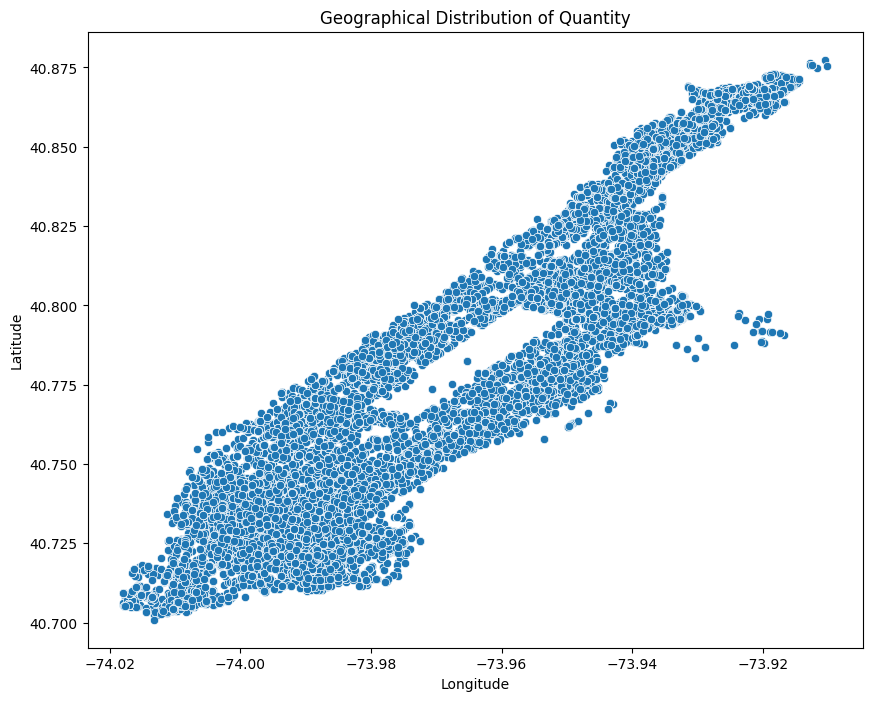

In [25]:
# Quick peek at the lat/lng coverage before we start merging things
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_complaints, x='Longitude', y='Latitude', palette='viridis', sizes=(20, 200), legend=True)
plt.title('Geographical Distribution of Quantity')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Feeling pretty confident about the coverage across the city

### Group the complaints by time and segment id

In [26]:
df_complaints = df_complaints.groupby(['Timestamp_Rounded', 'SegmentId']).size().reset_index(name='Count')

In [27]:
df_complaints['Timestamp'] = df_complaints['Timestamp_Rounded']
df_complaints['Month'] = df_complaints['Timestamp_Rounded'].dt.month
df_complaints['DayOfMonth'] = df_complaints['Timestamp_Rounded'].dt.day
df_complaints['DayOfWeek'] = df_complaints['Timestamp_Rounded'].dt.dayofweek
df_complaints['Hour'] = df_complaints['Timestamp_Rounded'].dt.hour

df_complaints.head()

,Timestamp_Rounded,SegmentId,Count,Timestamp,Month,DayOfMonth,DayOfWeek,Hour
0,2024-01-01,0018123,0,2024-01-01,1,1,0,0
1,2024-01-01,0018126,0,2024-01-01,1,1,0,0
2,2024-01-01,0018129,0,2024-01-01,1,1,0,0
3,2024-01-01,0018136,0,2024-01-01,1,1,0,0
4,2024-01-01,0018141,0,2024-01-01,1,1,0,0


In [28]:
df_complaints.sort_values(by=['Count'], ascending=False).head(10)

,Timestamp_Rounded,SegmentId,Count,Timestamp,Month,DayOfMonth,DayOfWeek,Hour
6130823,2024-02-19 14:00:00,0037188,11,2024-02-19 14:00:00,2,19,0,14
10166010,2024-03-22 17:00:00,0037188,10,2024-03-22 17:00:00,3,22,4,17
14285373,2024-04-24 17:00:00,0037188,10,2024-04-24 17:00:00,4,24,2,17
7713026,2024-03-03 03:00:00,0032165,10,2024-03-03 03:00:00,3,3,6,3
5778336,2024-02-16 18:00:00,0037188,10,2024-02-16 18:00:00,2,16,4,18
16632894,2024-05-13 08:00:00,0072741,10,2024-05-13 08:00:00,5,13,0,8
15537491,2024-05-04 15:00:00,0037188,10,2024-05-04 15:00:00,5,4,5,15
14153848,2024-04-23 16:00:00,0037188,9,2024-04-23 16:00:00,4,23,1,16
12501894,2024-04-10 12:00:00,0037188,8,2024-04-10 12:00:00,4,10,2,12
75381,2024-01-01 14:00:00,0037084,8,2024-01-01 14:00:00,1,1,0,14


In [30]:
df_complaints['Count'].value_counts()

Count
0     18450185
1        33456
2         2617
3          573
4          197
5           72
6           26
7           18
10           6
8            2
11           1
9            1
Name: count, dtype: int64

In [33]:
check_segment_coverage(lion_gdf, df_complaints)

5261/28497 represented in dataset (18%)


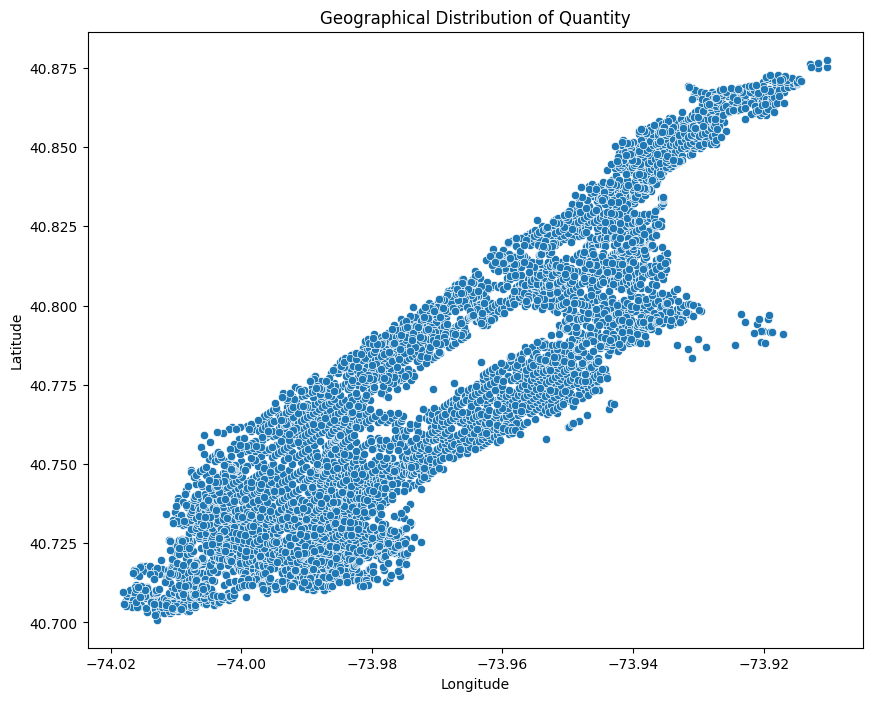

In [85]:
map_segments(lion_gdf, df_complaints)

So far, the vast majority of our data is 0s

### Inserting all the negative data

In [87]:
check_date_coverage(df_complaints)

Date range: 2024-01-01 00:00:00 - 2024-05-28 01:00:00
Expect 3554 datetime entries
have 3514 days covered


In [91]:
def insert_negative_values(df):
    date_range = check_date_coverage(df)
    # Create a "base" dataframe - all segments at all hours
    all_segment_ids = df['SegmentId'].unique()

    # Create a MultiIndex from the cartesian product of segment_ids and datetime_values
    multi_index = pd.MultiIndex.from_product([all_segment_ids, date_range], names=['SegmentId', 'Timestamp'])

    # Convert the MultiIndex to a DataFrame
    df_base = pd.DataFrame(index=multi_index).reset_index()
    # Add all the other columns
    df_base['Timestamp_Rounded'] = df_base['Timestamp']
    df_base['Timestamp'] = df_base['Timestamp_Rounded']
    df_base['Month'] = df_base['Timestamp_Rounded'].dt.month
    df_base['DayOfMonth'] = df_base['Timestamp_Rounded'].dt.day
    df_base['DayOfWeek'] = df_base['Timestamp_Rounded'].dt.dayofweek
    df_base['Hour'] = df_base['Timestamp_Rounded'].dt.hour
    df_base['Count'] = 0

    df_merged = df_base.merge(df, on=['SegmentId', 'Timestamp'], how='left', suffixes=('', '_subset'))
    df_merged['Count'] = df_merged['Count_subset'].combine_first(df_merged['Count'])
    df_merged.drop(columns=['Count_subset'], inplace=True)

    df_merged.info()
    return df_merged


Now merge the existing data into the base date

In [92]:
df_merged = insert_negative_values(df_complaints)

Date range: 2024-01-01 00:00:00 - 2024-05-28 01:00:00
Expect 3554 datetime entries
have 3514 days covered
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18697594 entries, 0 to 18697593
Data columns (total 13 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   SegmentId                 category      
 1   Timestamp                 datetime64[ns]
 2   Timestamp_Rounded         datetime64[ns]
 3   Month                     int32         
 4   DayOfMonth                int32         
 5   DayOfWeek                 int32         
 6   Hour                      int32         
 7   Count                     float64       
 8   Timestamp_Rounded_subset  datetime64[ns]
 9   Month_subset              float64       
 10  DayOfMonth_subset         float64       
 11  DayOfWeek_subset          float64       
 12  Hour_subset               float64       
dtypes: category(1), datetime64[ns](3), float64(5), int32(4)
memory usage: 1.4 GB


### Do some quick graphs

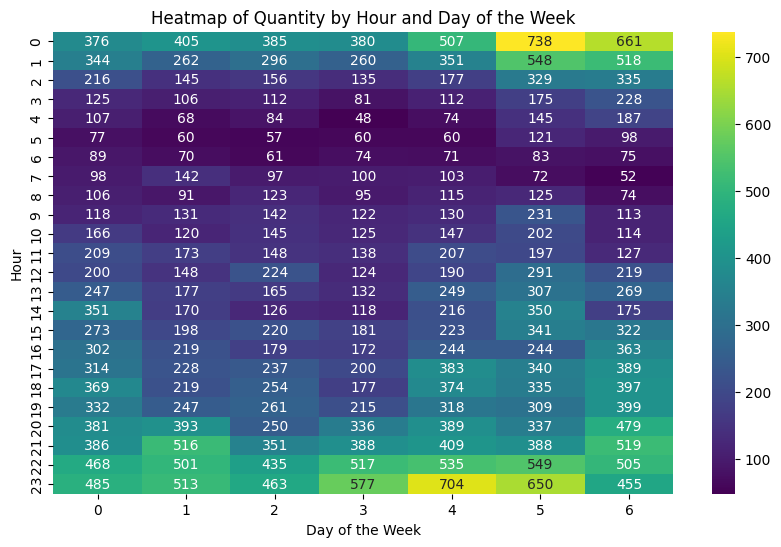

In [93]:
# Pivot table for heatmap
heatmap_data = df_merged.pivot_table(index='Hour', columns='DayOfWeek', values='Count', aggfunc='sum')

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt='g', cmap='viridis')
plt.title('Heatmap of Quantity by Hour and Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Hour')
plt.show()

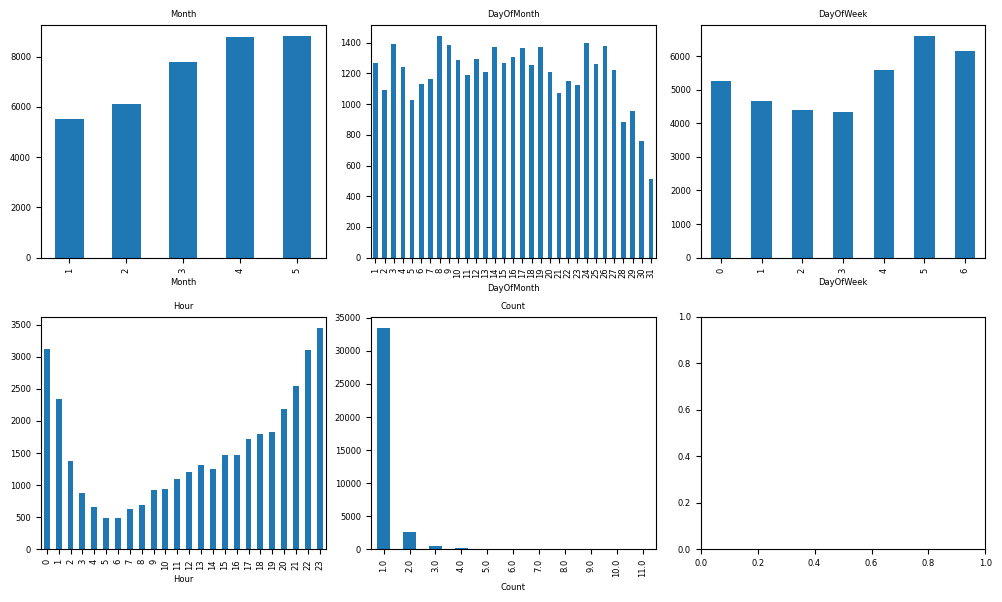

In [94]:
plt.rc('font', size=6)          
plt.rc('axes', titlesize=6)     
plt.rc('axes', labelsize=6)   
plt.rc('xtick', labelsize=6)    
plt.rc('ytick', labelsize=6)
plt.rc('legend', fontsize=6)
plt.rc('figure', titlesize=8)

# Look at the non-0s
with_counts_only = df_merged[df_merged['Count'] > 0]

# Create a figure with a grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))  # 2x2 grid

# List of columns to plot
columns = ['Month', 'DayOfMonth', 'DayOfWeek', 'Hour', 'Count']

# Plot each column in the respective subplot
for ax, column in zip(axes.flatten(), columns):
    with_counts_only[column].value_counts(dropna=True).sort_index().plot(kind='bar', ax=ax, title=column)

# Adjust layout
plt.tight_layout()
plt.show()

In [96]:
df_merged['Count'].value_counts()

Count
0.0     18660625
1.0        33456
2.0         2617
3.0          573
4.0          197
5.0           72
6.0           26
7.0           18
10.0           6
8.0            2
11.0           1
9.0            1
Name: count, dtype: int64

Amount of 0s is quite high, so lets see

# Build a model

In [97]:
df_merged.dtypes

SegmentId                         category
Timestamp                   datetime64[ns]
Timestamp_Rounded           datetime64[ns]
Month                                int32
DayOfMonth                           int32
DayOfWeek                            int32
Hour                                 int32
Count                              float64
Timestamp_Rounded_subset    datetime64[ns]
Month_subset                       float64
DayOfMonth_subset                  float64
DayOfWeek_subset                   float64
Hour_subset                        float64
dtype: object

In [98]:
df_complaints_modeling = df_merged
df_complaints_modeling['SegmentId'] = df_complaints_modeling['SegmentId'].astype('category')
df_complaints_modeling['Month'] = df_complaints_modeling['Month'].astype('category')
df_complaints_modeling['DayOfMonth'] = df_complaints_modeling['DayOfMonth'].astype('category')
df_complaints_modeling['DayOfWeek'] = df_complaints_modeling['DayOfWeek'].astype('category')
df_complaints_modeling['Hour'] = df_complaints_modeling['Hour'].astype('category')

df_complaints_modeling.dtypes

SegmentId                         category
Timestamp                   datetime64[ns]
Timestamp_Rounded           datetime64[ns]
Month                             category
DayOfMonth                        category
DayOfWeek                         category
Hour                              category
Count                              float64
Timestamp_Rounded_subset    datetime64[ns]
Month_subset                       float64
DayOfMonth_subset                  float64
DayOfWeek_subset                   float64
Hour_subset                        float64
dtype: object

In [99]:
# Because count has such a small range, we will treat as categorical
df_complaints_modeling['Count'] = df_complaints_modeling['Count'].astype('category')

In [100]:
df_complaints_modeling.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18697594 entries, 0 to 18697593
Data columns (total 13 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   SegmentId                 category      
 1   Timestamp                 datetime64[ns]
 2   Timestamp_Rounded         datetime64[ns]
 3   Month                     category      
 4   DayOfMonth                category      
 5   DayOfWeek                 category      
 6   Hour                      category      
 7   Count                     category      
 8   Timestamp_Rounded_subset  datetime64[ns]
 9   Month_subset              float64       
 10  DayOfMonth_subset         float64       
 11  DayOfWeek_subset          float64       
 12  Hour_subset               float64       
dtypes: category(6), datetime64[ns](3), float64(4)
memory usage: 1.1 GB


In [102]:
models = {}
predictions = {}

In [103]:
FEATURES = ['Month', 'DayOfMonth', 'DayOfWeek', 'Hour', 'SegmentId'] # Timestamp?
# FEATURES = ['DayOfWeek', 'Hour', 'SegmentId'] # Timestamp?
TARGET = ['Count']

In [164]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler


Splitting data

In [189]:
count_0 = len(df_complaints_modeling[df_complaints_modeling["Count"] == 0])
count_gt_0 = len(df_complaints_modeling[df_complaints_modeling["Count"] != 0])
print(f"{count_0} counts are 0")
print(f"{count_gt_0} counts are greater")
df_complaints_modeling["Count"].value_counts()

18660625 counts are 0
36969 counts are greater


Count
0.0     18660625
1.0        33456
2.0         2617
3.0          573
4.0          197
5.0           72
6.0           26
7.0           18
10.0           6
8.0            2
9.0            1
11.0           1
Name: count, dtype: int64

In [190]:
# Oversample the 0 counts by pulling out the average amount of the others
sample_of_0s = df_complaints_modeling[df_complaints_modeling["Count"] == 0].sample(random_state=42, n=3300)
data_sample = df_complaints_modeling[df_complaints_modeling["Count"] != 0]
data_sample = pd.concat([data_sample, sample_of_0s])

data_sample = data_sample.sample(random_state=42, n=5000) 

X = data_sample[FEATURES]
y = data_sample[TARGET]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [193]:
y_train.value_counts()

Count
1.0      3067
0.0       327
2.0       263
3.0        57
4.0        22
5.0        11
6.0         3
7.0         0
8.0         0
9.0         0
10.0        0
11.0        0
Name: count, dtype: int64

In [194]:
#Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [115]:
# TODO: we can only do log for yes/no
# reg = LogisticRegression(random_state = 42)
# accuracies = cross_val_score(reg, X_train, y_train, cv=5)
# reg.fit(X_train,y_train)
# y_pred = reg.predict(X_test)

#Obtain accuracy
# print("Train Score:",np.mean(accuracies))
# print("Test Score:",reg.score(X_test,y_test))

In [180]:
# Logistic Regression
# log_reg = LogisticRegression()
# model_log_reg = log_reg.fit(X_train_scaled, y_train)
# y_pred_log_reg = log_reg.predict(X_test_scaled)
# print("Logistic Regression MSE:", mean_squared_error(y_test, y_pred_log_reg))

# models['LogisticRegression'] = model_log_reg
# predictions['LogisticRegression'] = y_pred_log_reg

# mse = mean_squared_error(y_test, y_pred_log_reg)
# print(f'Mean Squared Error: {mse}')
# r2 = r2_score(y_test, y_pred_log_reg)
# print(f'R-squared: {r2}')

Logistic Regression MSE: 0.0029781905105977532


In [195]:
from sklearn.neighbors import KNeighborsClassifier

# K Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=3)
accuracies = cross_val_score(knn, X_train, y_train, cv=5)

model_knn = knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print("KNN MSE:", mean_squared_error(y_test, y_pred_knn))

models['KNN'] = model_knn
predictions['KNN'] = y_pred_knn

print("Train Score:",np.mean(accuracies))
print("Test Score:",knn.score(X_test,y_test))


KNN MSE: 0.456
Train Score: 0.7696
Test Score: 0.796


In [152]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       198
         1.0       0.00      0.00      0.00         2

    accuracy                           0.99       200
   macro avg       0.49      0.50      0.50       200
weighted avg       0.98      0.99      0.99       200



In [125]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
accuracies = cross_val_score(rf, X_train, y_train, cv=5)
model_rf = rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest MSE:", mean_squared_error(y_test, y_pred_rf))

models['RandomForest'] = model_rf
predictions['RandomForest'] = y_pred_rf

print("Train Score:",np.mean(accuracies))
print("Test Score:",rf.score(X_test,y_test))

Random Forest MSE: 0.01
Train Score: 0.99875
Test Score: 0.99


Evidently, all of these models are absolute shit. Going to pull out all 

### Linear regression

In [135]:
from sklearn.linear_model import LinearRegression

In [136]:
model_linear = LinearRegression()
model_linear.fit(X_train, y_train)
models['linear_regression'] = model_linear

In [137]:
y_pred_linear = model_linear.predict(X_test)
predictions['linear_regression'] = y_pred_linear

In [139]:
mae = mean_absolute_error(y_test, y_pred_linear)
print(f'Mean Absolute Error: {mae}')
mse = mean_squared_error(y_test, y_pred_linear)
print(f'Mean Squared Error: {mse}')
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')
r2 = r2_score(y_test, y_pred_linear)
print(f'R-squared: {r2}')

Mean Absolute Error: 0.2411069387222996
Mean Squared Error: 0.25458659591312693
Root Mean Squared Error: 0.5045657498415117
R-squared: 0.004821562925992118


In [ ]:
residuals = y_test - y_pred_linear

plt.figure(figsize=(8, 6))
plt.scatter(y_pred_linear, residuals, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

Awful!

### Random Forest

In [141]:
from sklearn.ensemble import RandomForestRegressor

In [145]:
model_rf = RandomForestRegressor(n_estimators=100)
model_rf.fit(X_train, y_train.values.ravel())
models['random_forest'] = model_rf

In [146]:
y_pred_rf = model_rf.predict(X_test)
predictions['random_forest'] = y_pred_rf

In [147]:
mae = mean_absolute_error(y_test, y_pred_rf)
print(f'Mean Absolute Error: {mae}')
mse = mean_squared_error(y_test, y_pred_rf)
print(f'Mean Squared Error: {mse}')
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')
r2 = r2_score(y_test, y_pred_rf)
print(f'R-squared: {r2}')

Mean Absolute Error: 0.2160467213114754
Mean Squared Error: 0.2382475655737705
Root Mean Squared Error: 0.4881061007340213
R-squared: 0.06869079617491791


### Gradient boosting

In [149]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV

In [150]:
# Convert to DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:Count: category

In [123]:
# Define model parameters
params = {
    'objective': 'reg:squarederror',
    'tree_method': 'hist',          # Efficient tree building
    'enable_categorical': True,     # Enable categorical data handling
}

# Train the model
model_gb = xgb.train(params, dtrain, num_boost_round=100)
models['gradient_boosting'] = model_gb

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [11:09:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "enable_categorical" } are not used.

  warnings.warn(smsg, UserWarning)


In [125]:
# Predict
y_pred_gb = model_gb.predict(dtest)
predictions['gradient_boosting'] = y_pred_gb

In [126]:
mae = mean_absolute_error(y_test, y_pred_gb)
print(f'Mean Absolute Error: {mae}')
mse = mean_squared_error(y_test, y_pred_gb)
print(f'Mean Squared Error: {mse}')
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')
r2 = r2_score(y_test, y_pred_gb)
print(f'R-squared: {r2}')

Mean Absolute Error: 0.20428392154271485
Mean Squared Error: 0.2526073228016272
Root Mean Squared Error: 0.5026005598898863
R-squared: 0.012558537115776591
